In [2]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
df = pd.read_csv('data.csv')

In [4]:
df.columns = df.columns.str.lower().str.replace(' ','_')

string_columns = list(df.dtypes[df.dtypes == 'object'].index)

for col in string_columns:
    df[col] = df[col].str.lower().str.replace(' ','_')

In [5]:
df.head()

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
0,bmw,1_series_m,2011,premium_unleaded_(required),335.0,6.0,manual,rear_wheel_drive,2.0,"factory_tuner,luxury,high-performance",compact,coupe,26,19,3916,46135
1,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,convertible,28,19,3916,40650
2,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,high-performance",compact,coupe,28,20,3916,36350
3,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,coupe,28,18,3916,29450
4,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,luxury,compact,convertible,28,18,3916,34500


<AxesSubplot:xlabel='msrp', ylabel='Count'>

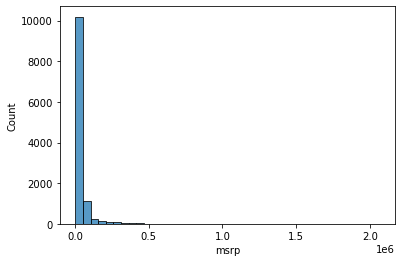

In [6]:
sns.histplot(df.msrp, bins=40)

In [7]:
log_price = np.log1p(df.msrp)

<AxesSubplot:xlabel='msrp', ylabel='Count'>

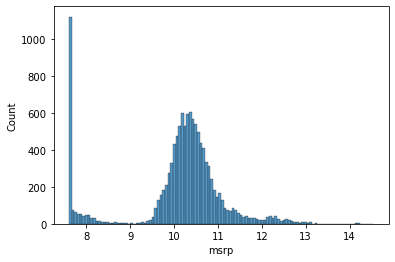

In [8]:
sns.histplot(log_price)

In [9]:
n = len(df)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

np.random.seed(2)
idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = df.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train + n_val].copy()
df_test = df_shuffled.iloc[n_train + n_val:].copy()

In [10]:
y_train = np.log1p(df_train.msrp.values)
y_val = np.log1p(df_val.msrp.values)
y_test = np.log1p(df_test.msrp.values)

In [11]:
del df_train['msrp']
del df_val['msrp']
del df_test['msrp']

In [12]:
base = ['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg', 'popularity']
df_num = df_train[base]

In [13]:
df_num = df_num.fillna(0)

In [14]:
X_train = df_num.values

In [15]:
def dot(xi, w):
    n = len(w)
    result = 0.0
    for j in range(n):
        result = result + xi[j] * w[j]
    return result

In [16]:
def linear_regression(xi):
    xi = [1] + xi
    return dot(xi, w)

In [17]:
def train_linear_regression(X, y, r = 0.0):
    # adding the dummy column
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    
    # normal equation formula
    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg
    
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [18]:
w_0, w = train_linear_regression(X_train, y_train)

In [19]:
y_pred = w_0 + X_train.dot(w)

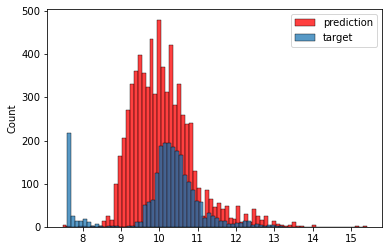

In [20]:
sns.histplot(y_pred, label = 'prediction', color = 'red')
sns.histplot(y_val, label = 'target')
plt.legend()

In [21]:
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [22]:
#rmse(y_train, y_pred)

In [23]:
df_num = df_val[base]
df_num = df_num.fillna(0)
X_val = df_num.values

In [24]:
y_pred = w_0 + X_val.dot(w)

In [25]:
rmse(y_val, y_pred)

0.7616530991301601

In [26]:
def binary_encoding(varName, catName, df, fts, n=20):
    arr = df_train[catName].value_counts().index.tolist()[:n]
    for v in arr:
        feature = varName + '_%s' % v
        df[feature] = (df[catName] == v).astype(int)
        fts.append(feature)

In [27]:
def prepare_X(df):
    df = df.copy()
    features = base.copy()
    
    df['age'] = 2017 - df.year
    features.append('age')
                                        
    binary_encoding('num_doors', 'number_of_doors', df, features)
    binary_encoding('is_make', 'make', df, features)
    binary_encoding('is_type', 'engine_fuel_type', df, features)
    binary_encoding('is_transmission', 'transmission_type', df, features)
    binary_encoding('is_driven_wheels', 'driven_wheels', df, features)
    binary_encoding('is_mc', 'market_category', df, features)
    binary_encoding('is_size', 'vehicle_size', df, features)
    binary_encoding('is_style', 'vehicle_style', df, features)
    
    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [28]:
X_train = prepare_X(df_train)
w_0, w = train_linear_regression(X_train, y_train, 0.001)

X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)
print('validation: ', rmse(y_val, y_pred))

X_test = prepare_X(df_test)
y_pred = w_0 + X_test.dot(w)
print('test: ', rmse(y_test, y_pred))

print(w)

validation:  0.4290842956973889
test:  0.4278215446685969
[ 1.43637753e-03  9.36715494e-02 -5.37693078e-03 -1.35011648e-02
  1.25556229e-04 -1.00015747e-01 -1.36614308e-01 -3.90048439e-01
 -2.98169352e-01 -1.83523526e-01 -7.34779684e-01 -8.44520186e-02
 -3.91696350e-01 -3.24063322e-01 -4.79878545e-01 -2.23405470e-02
  6.51655758e-03 -1.48449001e-02 -2.86503090e-01  1.41911881e-01
 -3.17443128e-01 -6.00839365e-01 -9.92136204e-03 -5.09864522e-01
 -2.39340816e-01 -1.61101579e-01  1.05502828e-02 -2.12868746e-01
 -3.68238577e-01 -3.57499543e-01  1.79128026e-01 -1.61672382e-01
 -4.68219517e-01  8.90184078e-02  2.19384692e+00  1.32893254e-01
 -8.20851249e-02  5.64318733e-03  1.31318180e+00  1.13921221e+00
  1.29241622e+00  1.29507257e+00  7.25952082e-01  1.41218631e+00
  1.43520308e+00  1.46812591e+00  1.45071840e+00 -1.11611436e-01
  9.75740197e-02 -9.46906427e-02 -9.27437219e-02 -1.49578735e-01
 -1.67877591e-01 -1.24752471e-01 -1.39439310e-01  3.16353847e-01
 -1.14943819e-01 -1.15597042e-01

# Car Price Finder

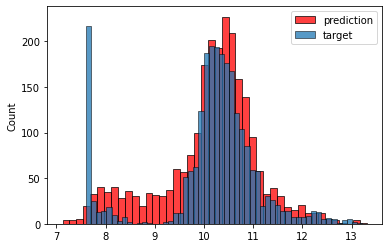

In [29]:
sns.histplot(y_pred, label = 'prediction', color = 'red')
sns.histplot(y_val, label = 'target')
plt.legend()

In [30]:
ad = {'make': 'gmc',
 'model': 'yukon',
 'year': 2014,
 'engine_fuel_type': 'regular_unleaded',
 'engine_hp': 355.0,
 'engine_cylinders': 8.0,
 'transmission_type': 'automatic',
 'driven_wheels': 'four_wheel_drive',
 'number_of_doors': 4.0,
 'market_category': 'crossover,performance',
 'vehicle_size': 'large',
 'vehicle_style': '4dr_suv',
 'highway_mpg': 20,
 'city_mpg': 16,
 'popularity': 549}

In [36]:
X_train = prepare_X(df_train)
w_0, w = train_linear_regression(X_train, y_train, 0.001)

df_test = pd.DataFrame([ad])
X_test = prepare_X(df_test)

y_pred = w_0 + X_test.dot(w)

suggestion = np.expm1(y_pred)
suggestion

array([58415.85378462])

In [9]:
a = df['make'].value_counts().head(15)
print(a)

chevrolet        1123
ford              881
volkswagen        809
toyota            746
dodge             626
nissan            558
gmc               515
honda             449
mazda             423
cadillac          397
mercedes-benz     353
suzuki            351
bmw               334
infiniti          330
audi              328
Name: make, dtype: int64
